In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle 
import glob
from tracker import tracker
%matplotlib inline


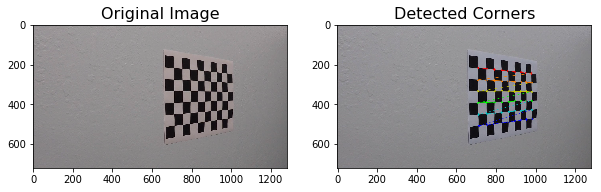

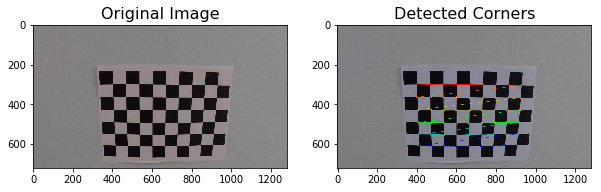

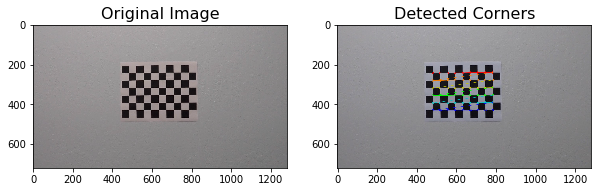

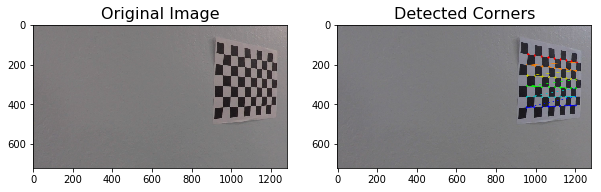

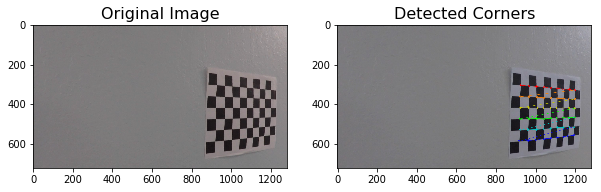

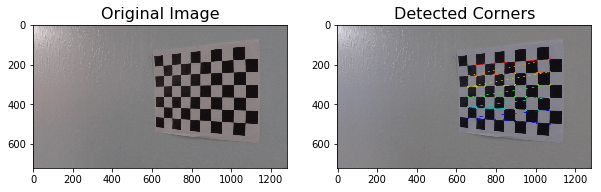

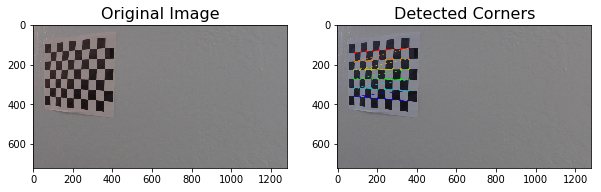

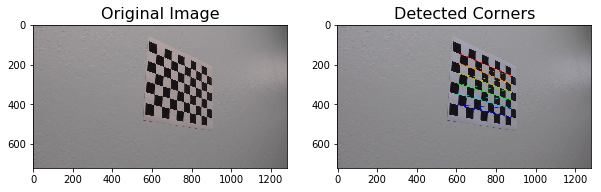

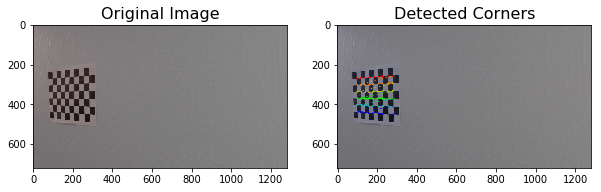

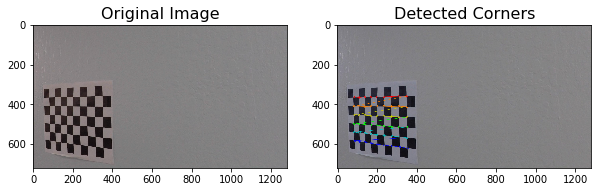

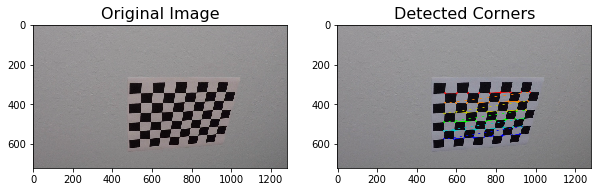

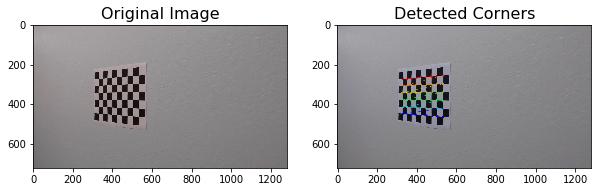

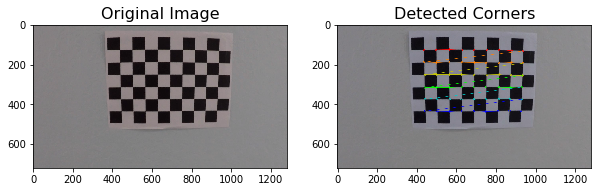

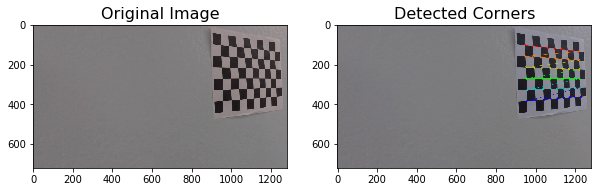

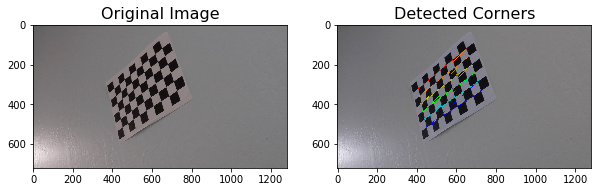

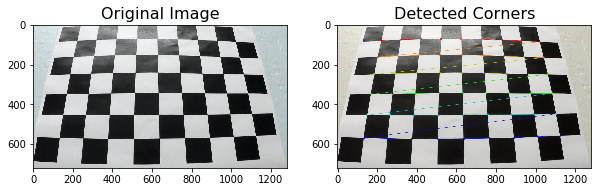

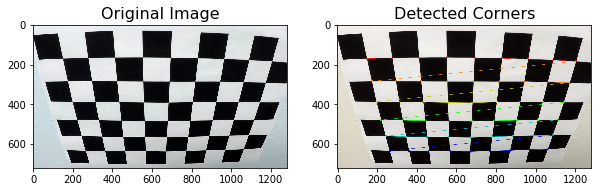

In [14]:
import glob
#Creating an array of object points like (0,0,0) (1,0,0) .... (9,6,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Directory to look for calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Detected Corners', fontsize=16)

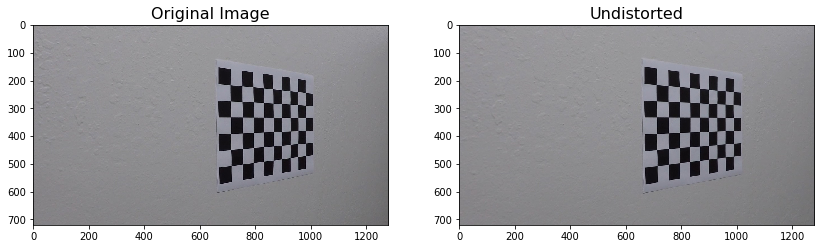

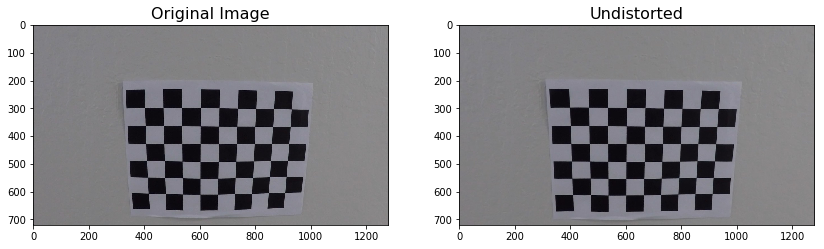

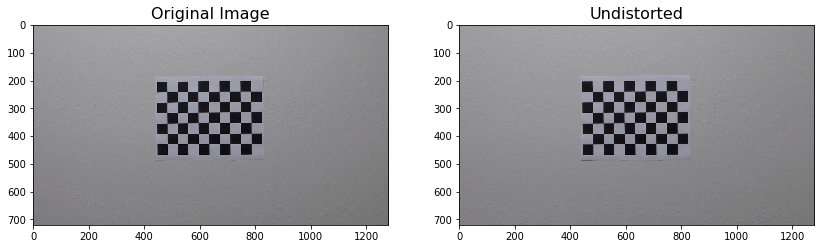

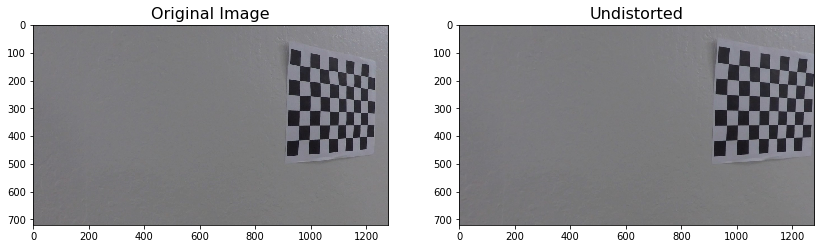

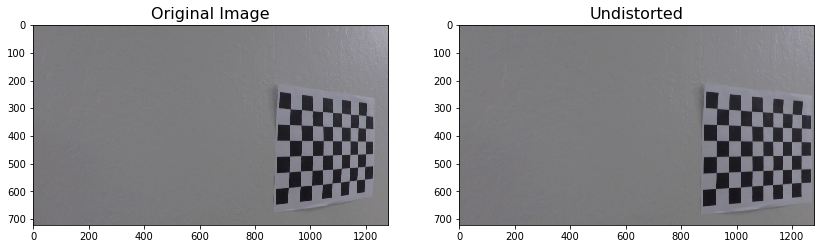

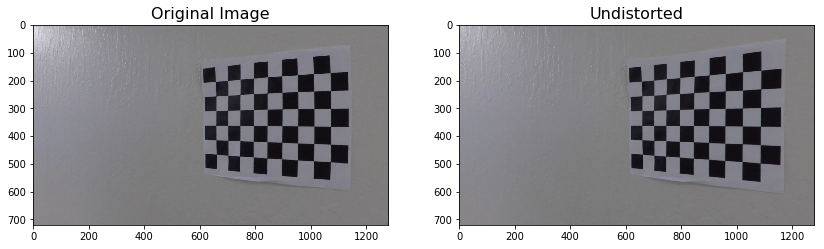

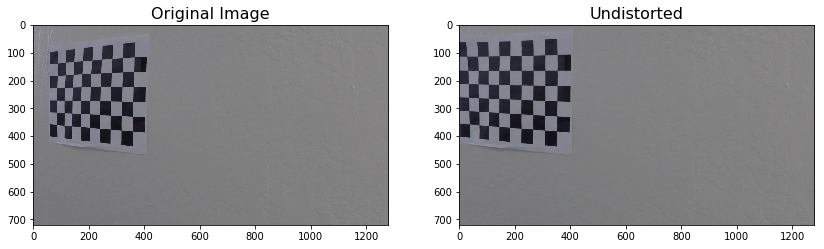

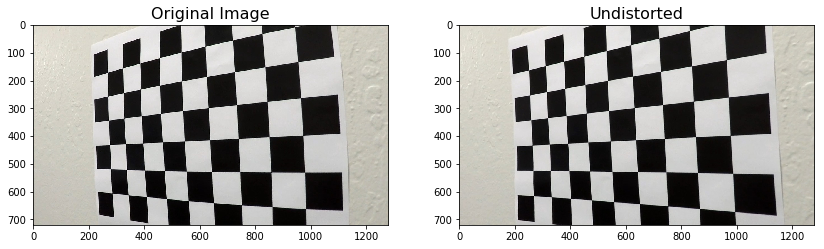

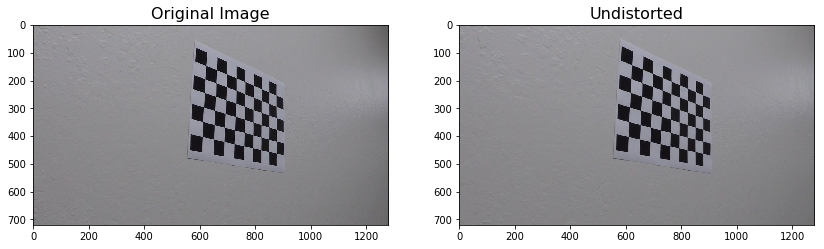

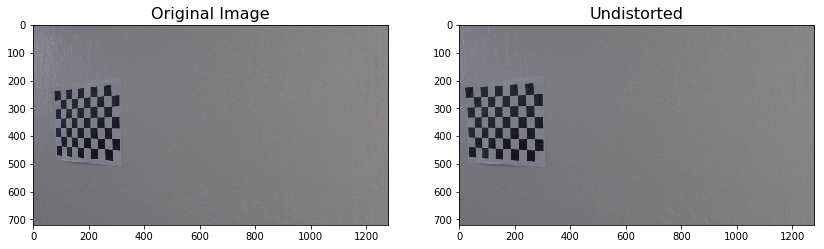

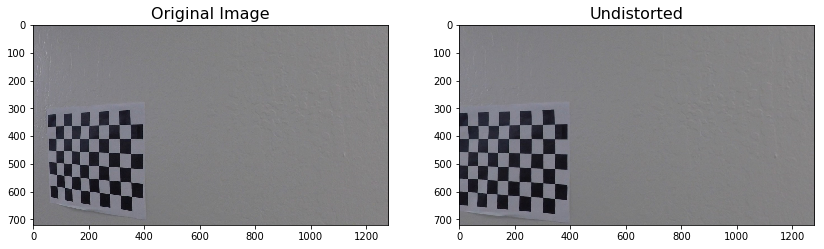

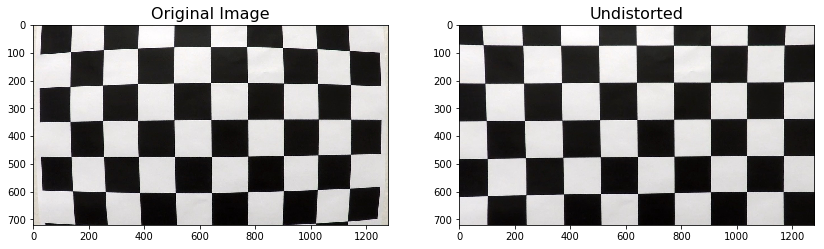

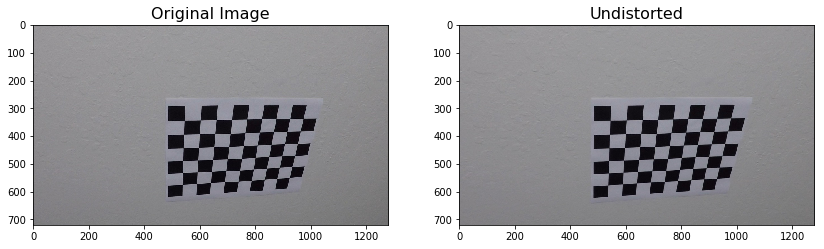

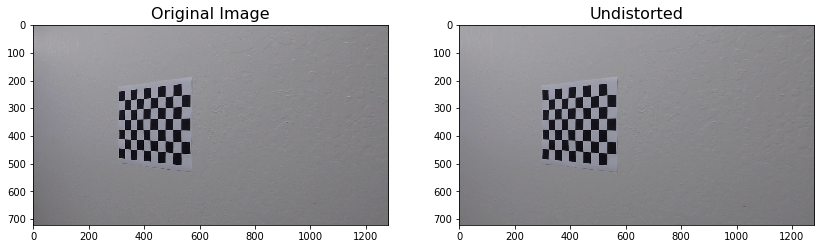

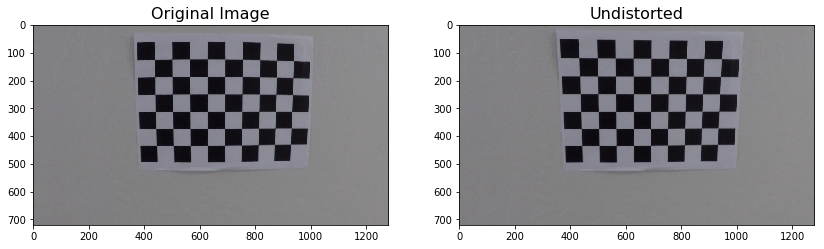

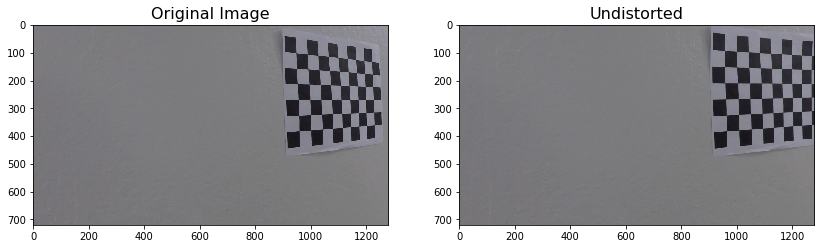

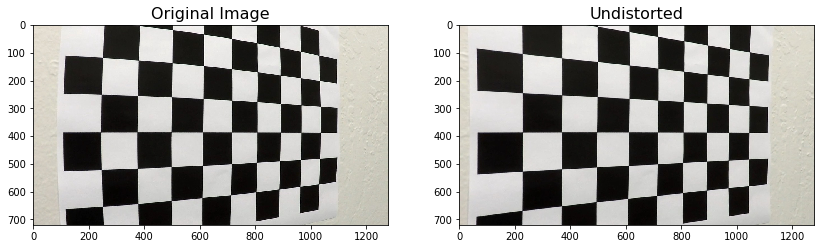

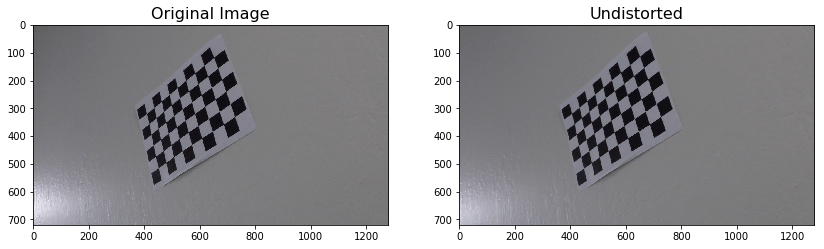

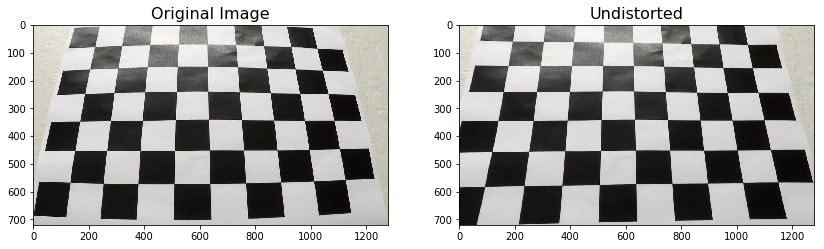

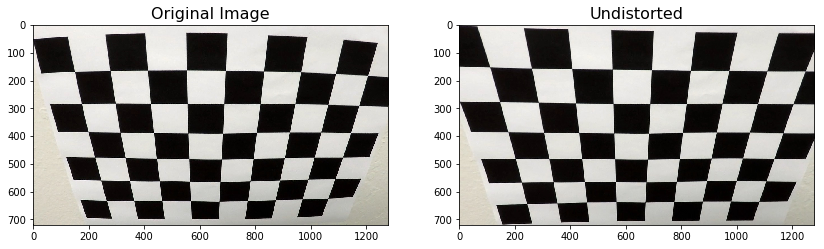

In [15]:
images=glob.glob('camera_cal/calibration*.jpg') 
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted', fontsize=16)

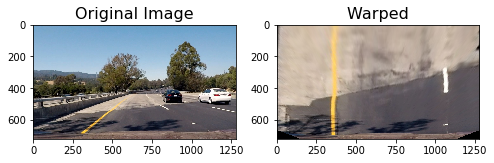

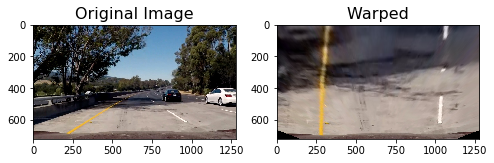

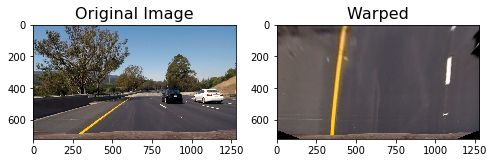

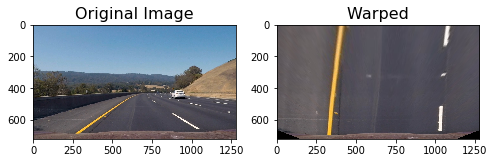

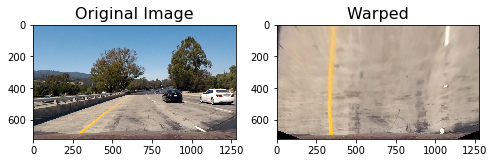

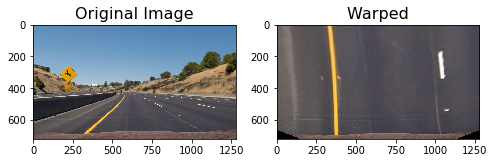

In [34]:
images=glob.glob('test_images/test*.jpg') 
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1],img.shape[0])
    bot_width = 0.76 #percent of bottom trapizoid height
    mid_width = 0.08 
    height_pct = 0.62
    bottom_trim = 0.935
    src=np.float32([[550,480], [730, 480], [195, 720], [1085, 720]])
    dst=np.float32([[300,0], [980,0], [300,720], [980,720]])
#     src = np.float32([[img.shape[1]*(0.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],
#                       [img.shape[1]*(0.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2),img.shape[0]*bottom_trim]])
#     offset = img_size[0]* 0.25
#     dst = np.float32([[offset, 0],[img_size[0]-offset,0],[img_size[0]-offset, img_size[1]],[offset, img_size[1]]])
    img_size=(img.shape[1], img.shape[0])
    M=cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped', fontsize=16)

## Image Pipeline

In [39]:
dist_pickle = pickle.load(open("calibration_pickle.p","rb"))
mtx=dist_pickle[0]
dist=dist_pickle[1]

#Useful functions for producing the binary pixel of interest images to feed into the LineTracker
def abs_sobel_thresh(img, orient='x',sobel_kernel=3,thresh=(0,255)):
    #Calculate directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient=='y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    #Apply threshold
    binary_output[(scaled_sobel>=thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0,255)):
    #Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag= (gradmag/scale_factor).astype(np.uint8)


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi*2)):
    #Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    with np.arrstate(divide='ignore',invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output = np.zeros_like(absgraddir)
        #Apply threshold
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    #For creating binary threshold images
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1]) ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1]) ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), max(0,int(center-width)):min(int(center+width), img_ref.shape[1])] = 1 #
    return output


    
def process_image(img):
    img = cv2.undistort(img,mtx,dist,None,mtx)

    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient= 'x', thresh=(12,255))
    grady = abs_sobel_thresh(img, orient= 'y',thresh=(25,255))
    c_binary = color_threshold(img, sthresh=(100,255),vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255

    #work on defining perspective transformation area
    img_size = (img.shape[1],img.shape[0])
    bot_width = 0.76 #percent of bottom trapizoid height
    mid_width = 0.08 
    height_pct = 0.62
    bottom_trim = 0.935
#     src = np.float32([[img.shape[1]*(0.5-mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],
#                       [img.shape[1]*(0.5+bot_width/2),img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2),img.shape[0]*bottom_trim]])
#     offset = img_size[0]* 0.25
#     dst = np.float32([[offset, 0],[img_size[0]-offset,0],[img_size[0]-offset, img_size[1]],[offset, img_size[1]]])
    src=np.float32([[550,480], [730, 480], [195, 720], [1085, 720]])
    dst=np.float32([[300,0], [980,0], [300,720], [980,720]])
    
    #perform the transform 
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

    window_width = 25
    window_height = 80


    #set up the overall class to do all tracking
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height=window_height, Mymargin = 25, My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)

    window_centroids = curve_centers.find_window_centroids(warped)

    #Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    #points used to find the left and right lanes
    rightx=[]
    leftx=[]     

    #Go through each level and draw the Windows
    for level in range(0, len(window_centroids)):
        #Window_mask is a function to draw window area
        #add center value found in frame to the list of lane points per left, right
#         leftx.append(window_centroids[level][0])
#         rightx.append(window_centroids[level][1])
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1],level)
        #Add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | (l_mask == 1)] = 255
        r_points[(r_points == 255) | (r_mask == 1)] = 255

    #Draw the results
    template = np.array(r_points+ l_points, np.uint8) #add both left and right window pixels together
    zero_channel = np.zeros_like(template) #create a zero color channels
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) #make window pixel green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) #making the original road pixel 3 color channels
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) #Overlay the original road image with window results

    #fit the lane boundaries to the left, right, center positions found
    yvals = range(0, warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)

    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.uint32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))), np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road, [left_lane], color=[255,0,0])
    cv2.fillPoly(road, [right_lane], color=[0,0,255])
    cv2.fillPoly(road_bkg, [left_lane], color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

    road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags = cv2.INTER_LINEAR)

    base = cv2.addWeighted(img, 1.0, road_warped_bkg, -1.0, 0.0)
    result = cv2.addWeighted(img, 1.0, road_warped, 1.0, 0.0)

    ym_per_pix = curve_centers.ym_per_pix #meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix #meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.absolute(2*curve_fit_cr[0])

    #calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center - warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    #draw the text showing curvature, offset, and speed
    cv2.putText(result, 'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    
    return result
    

In [40]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    result=process_image(img)
    write_name = 'test_images/processed'+str(idx)+'.jpg'
    cv2.imwrite(write_name, result)

TypeError: expected x and y to have same length

In [19]:
processed=cv2.imread('test_images/')

In [ ]:
Output_video = 'output_tracked.mp4'
Input_video = 'harder_challenge_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(Output_video, audio=False)